In [1]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc

# Get the Sample Metadata

In [2]:
fpath = "../../config/sample_info.csv"
df = pd.read_csv(fpath)
df['Age'] = df['Condition'].apply(lambda x: x.split("_")[0])
df['Day'] = df['Condition'].apply(lambda x: x.split("_D")[1])
df.head()

,Barcode,Condition,Replicate,Age,Day
0,bc1,Young_D28,extra,Young,28
1,bc2,Young_D28,extra,Young,28
2,bc3,Young_D28,extra,Young,28
3,bc4,Young_D14,2,Young,14
4,bc5,Young_D14,3,Young,14


# Collect the Counts Data

In [3]:
dpath = "/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/"
file_list = glob.glob(f"{dpath}*")
file_list[:10]

['/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc1.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc14.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc13.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc5.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc9.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc3.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc8.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc4.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipeline_outputs/count_matrix/bc10.counts.tsv',
 '/scratch/indikar_root/indikar1/shared_data/chondroform/pipe

In [4]:
result = []

for fpath in file_list:
    basename = os.path.basename(fpath).replace(".counts.tsv", "")
    tmp = pd.read_csv(fpath, sep='\t')
    tmp.columns = ['gene_id', 'gene_name', basename]
    
    # drop genes without ids
    tmp = tmp[tmp['gene_id'].notna()]
    tmp = tmp[tmp['gene_name'].notna()]
    
    tmp = tmp.set_index(['gene_id', 'gene_name'])
    result.append(tmp)
    
    
result = pd.concat(result, axis=1, ignore_index=False)
result = result.reset_index()
result.head()

,gene_id,gene_name,bc1,bc14,bc13,bc5,bc9,bc3,bc8,bc4,bc10,bc12,bc15,bc6,bc11,bc2,bc7
0,ENSG00000000003,TSPAN6,252,90,116,308,271,219,267,184,138,150,69,130,129,224,190
1,ENSG00000000005,TNMD,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0
2,ENSG00000000419,DPM1,356,134,117,352,293,261,401,246,195,174,133,182,192,224,269
3,ENSG00000000457,SCYL3,78,39,43,47,53,65,89,38,81,19,36,40,75,55,48
4,ENSG00000000460,FIRRM,92,20,37,47,80,93,135,44,72,22,67,39,72,75,43


In [5]:
var = result[['gene_id', 'gene_name']].copy()
var = var.set_index('gene_name')
var.head()

,gene_id
gene_name,
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
FIRRM,ENSG00000000460


In [6]:
obs = df.copy()
obs = obs.set_index('Barcode')
obs.head()

,Condition,Replicate,Age,Day
Barcode,,,,
bc1,Young_D28,extra,Young,28
bc2,Young_D28,extra,Young,28
bc3,Young_D28,extra,Young,28
bc4,Young_D14,2,Young,14
bc5,Young_D14,3,Young,14


In [7]:
X = result.copy()
X = X.drop(columns=['gene_id'])
X = X.set_index('gene_name')
X = X.T
X = X.reindex(obs.index)

X.head()

gene_name,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LRRC77P,LINC00301,CUTALP,ZNF271P,GGNBP1,DMBT1L1,DUSP13B,DUSP13A,ALG1L9P,FAM169BP
Barcode,,,,,,,,,,,,,,,,,,,,,
bc1,252,0,356,78,92,0,0,56,8,10,...,0,0,27,5,5,0,0,0,1,0
bc2,224,0,224,55,75,0,0,61,2,9,...,0,0,35,8,4,0,0,0,0,0
bc3,219,0,261,65,93,1,0,58,11,5,...,0,0,15,8,3,0,0,0,0,0
bc4,184,1,246,38,44,0,0,46,3,7,...,0,0,37,4,6,0,0,0,0,0
bc5,308,1,352,47,47,1,0,66,7,10,...,0,0,31,6,6,0,0,0,0,0


# Build the AnnData Object

In [8]:
adata = an.AnnData(csr_matrix(X.to_numpy()))
adata.obs_names = X.index
adata.var_names = X.columns
adata.var = var
adata.obs = obs

adata.layers['raw_counts'] = adata.X.copy()

adata

AnnData object with n_obs × n_vars = 15 × 42640
    obs: 'Condition', 'Replicate', 'Age', 'Day'
    var: 'gene_id'
    layers: 'raw_counts'

# Simple additions to make life more fun

In [9]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mt", "ribo", "hb"], 
    log1p=False,
    inplace=True,
)

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e6)
adata.layers["norm"] = csr_matrix(adata.X.astype('float32').copy())
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

AnnData object with n_obs × n_vars = 15 × 42640
    obs: 'Condition', 'Replicate', 'Age', 'Day', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'raw_counts', 'norm', 'log_norm'

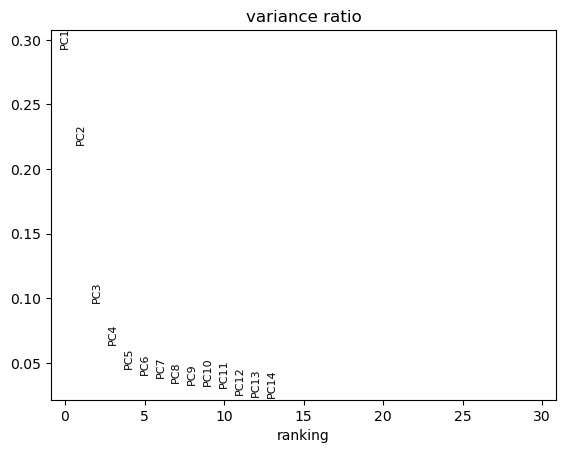

In [10]:
sc.pp.highly_variable_genes(
    adata,
)

sc.tl.pca(
    adata,
    mask_var='highly_variable',
)

sc.pl.pca_variance_ratio(adata)

In [11]:
sc.pp.neighbors(adata,)

sc.tl.umap(adata)

sc.tl.leiden(
    adata, 
    resolution=0.5, 
    key_added='cluster',
)

adata

/tmp/ipykernel_2542895/2350363546.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


AnnData object with n_obs × n_vars = 15 × 42640
    obs: 'Condition', 'Replicate', 'Age', 'Day', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'cluster'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cluster'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'norm', 'log_norm'
    obsp: 'distances', 'connectivities'

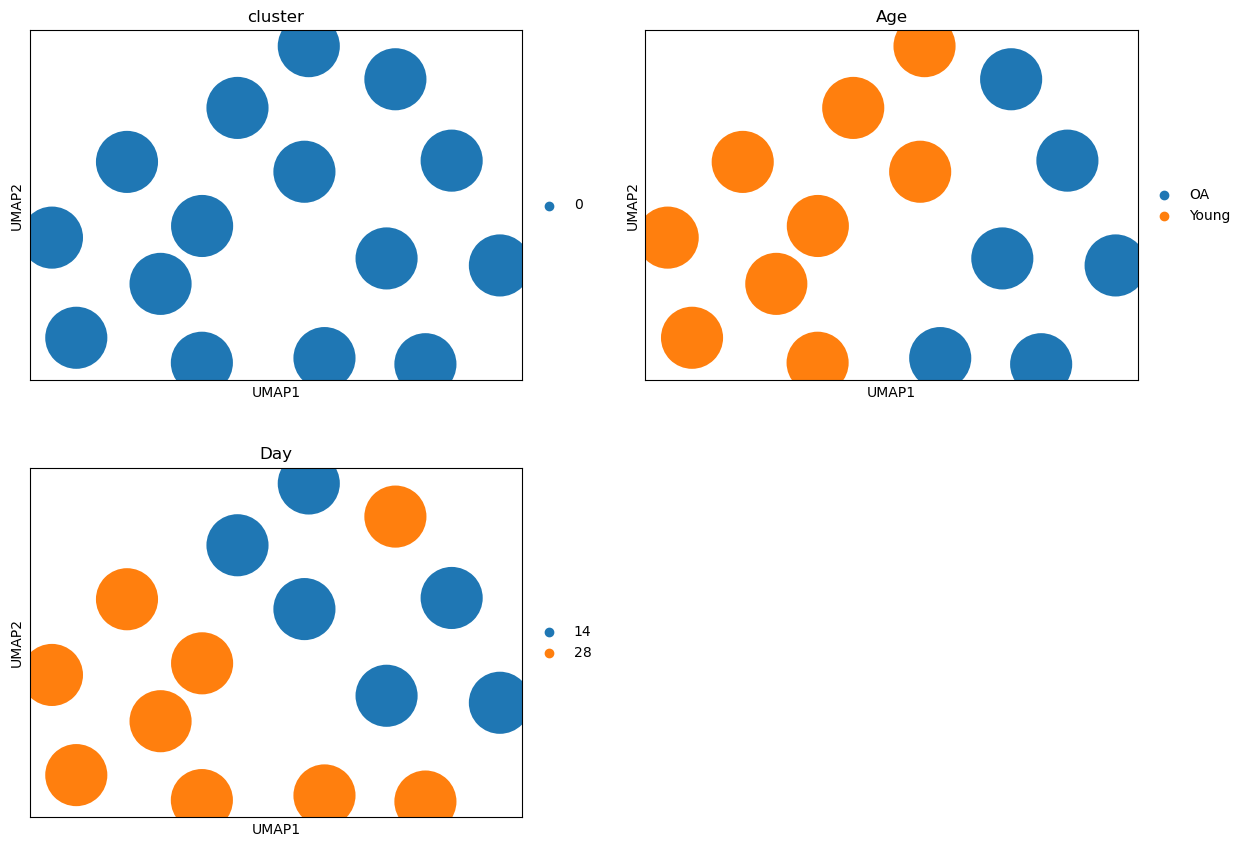

In [12]:
sc.pl.umap(
    adata,
    color=[
        'cluster', 
        'Age',
        'Day', 
    ],
    ncols=2,
)

In [13]:
outpath = "/scratch/indikar_root/indikar1/shared_data/chondroform/scanpy/chrondocyte_data.h5ad"
adata.write(outpath)

adata

AnnData object with n_obs × n_vars = 15 × 42640
    obs: 'Condition', 'Replicate', 'Age', 'Day', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'cluster'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cluster', 'cluster_colors', 'Age_colors', 'Day_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'norm', 'log_norm'
    obsp: 'distances', 'connectivities'